# Método numéricos

**EDE homogénea**

$dS_t = \mu S_tdt+\sigma S_tdB_t$

* Solución exacta: Método de Black Scholes
* Simulación Monte Carlo
* Árboles Binomiales

**Ecuación en derivadas parciales**
$\frac{\partial f}{\partial t} + rs \frac{\partial f}{\partial s} + \frac{1}{2}\sigma^2s^2 \frac{\partial^2 f}{\partial s^2} = rf$

**EDE de reversión a la media**

$dS_t = \alpha(\mu - S_t)dt+\sigma S_tdB_t$ o $dS_t = \alpha(\mu (t)- S_t)dt+\sigma S_tdB_t$

* No tiene solución exacta
* Simulación Monte Carlo
* Árboles binomiales

**Ecuación en derivadas parciales**
$\frac{\partial f}{\partial t} + rs \frac{\partial f}{\partial s} + \frac{1}{2}\sigma^2 \frac{\partial^2 f}{\partial s^2} = rf$

*Las ecuaciones neutralizadas:*
$dS_t = rS_tdt+\sigma S_tdB_t^*$

## Método de diferencias finitas

### Generalidades
* Para un dominio específico, la solución de una ED parcial con dos variables independientes es una superficie.
* La forma de la solución dependerá entonces de las condiciones de frontera.
* Las opciones siempre tienen la misma condición de frontera: $\max\{S_t - K, 0\}$.
* En un dominio numérico dado, se espera que la superficie esté en 0 hasta K.
* El dominio numérico debe ser acotado. Y lo vamos a definir con respecto a $T$ y $2S_0$.
* El dominio numérico será dividido uniformemente en dirección de $t$ en saltos de longitud $\Delta t$. Y en $s$, $\Delta s$


### Parámetros
* El $t_{max} = T$ y el $S_{max} = 2S_0$.
* $\Delta S$, tal que en la malla esté $S_0$.
* $K$ debe estar antes del $S_{max}$

### Método
Definimos $(i,j)$ un nodo de la malla, donde $i$ representa a $t$ y $j$ representa a $S$.
* $\frac{\partial f}{\partial S} \approx \frac{f_{i+1,j+1} - f_{i+1,j-1}}{2\Delta S}$
* $\frac{\partial f}{\partial t} \approx \frac{f_{i+1,j} - f_{i,j}}{\Delta t}$
* $\frac{\partial^2 f}{\partial S^2} \approx \frac{f_{i+1,j+1} + f_{i+1,j-1} - 2f_{i+1,j}}{(\Delta S)^2}$

**Paquetes necesarios**

In [4]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

**Parámetros**

In [5]:
""" Condiciones iniciales
    S_0   : Valor de acción en tiempo actual
    S_max : Cota superior de la acción
    dS    : Tamaño de intervalos del precio
    M     : Intervalos del precio
    T     : Tiempo de muestreo
    N     : Intervalos del tiempo
    dT    : Tamaños de intervalos del tiempo
"""
sigma = 0.3
S0 = 10
K = 1.1*S0
r = 0.05
S_max = 2*S0 
dS = 0.5   
M = int(np.ceil(S_max//dS))
T = 1/12
dT_tmp = (dS/(sigma*S_max))**2
N_tmp = T/dT_tmp
N = int(np.ceil(N_tmp))
dT = T/N;

In [6]:
a = np.zeros(M+1)
b = np.zeros(M+1)
c = np.zeros(M+1)
for j in range(M+1):
    a[j] = (dT/(1+r*dT)) * ((sigma**2 * j**2)/2 - (r * j/2))
    b[j] = (dT/(1+r*dT)) * ((1/dT) - sigma**2 * j**2)
    c[j] = (dT/(1+r*dT)) * ((sigma**2 * j**2)/2 + (r * j/2))

In [7]:
# Crear Malla F
F = np.zeros((N+1, M+1))

# Condiciones de frontera
F[:,0] = 0

for j in range(M):
    F[N, j] = max(j*dS - K, 0)

F[:, M] = S_max - K

for i in reversed(range(N)):
    for j in reversed(range(1, M)):
        F[i,j] = a[j] * F[i+1, j-1] + b[j] * F[i+1, j] + c[j] * F[i+1, j+1]

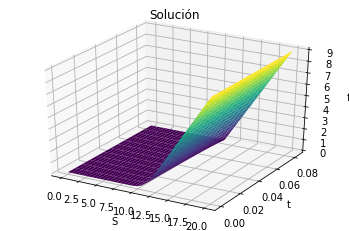

In [8]:
S = np.arange(0, S_max+dS, dS)
t = np.arange(0, T+dT, dT)
X = S
Y = t
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, F, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Solución');
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('f');

In [13]:
P = S0//dS;
FF = F[0,int(P)]
FF

0.0632336946173871

In [14]:
# Black Scholes
d1 = (np.log(S0/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
import scipy.stats as ss
N = ss.norm(0,1)
fcall = S0*N.cdf(d1) - K*np.exp(-r*T)*N.cdf(d2)
print('fcall:', fcall)

fcall: 0.06823206485851263


In [63]:
from tqdm import tqdm

100%|██████████| 1000/1000 [02:16<00:00,  7.74it/s]


Media:
0.9998696081201524
Mínimo:
0.44866752676057525
Máximo:
1.5752058184359368


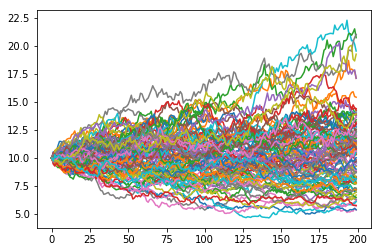

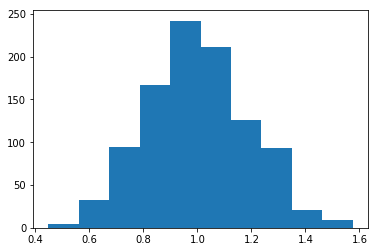

In [67]:
# PARÁMETROS
s0 =10
T =1
N = 200 
r = 0.05
sigma = 0.3
K = 1.1*s0 # Precio de ejercicio: Un 10% más del precio inicial
M = 1000
k = 100 # Número de trayectorias en cada simulación
dt = T/N
S = np.zeros([k,N]) # Filas cada tracyectoria, columnas el tiempo
payoff=np.zeros(k) #en cada simulacion saco el payoff de cada trayectoria
opcion=np.zeros(M) #Tantas opciones como simulaciones
for h in tqdm(range(M)):
    for i in range(k):
        S[i,0] = S0
    for i in range(k):
        for t in range(N-1):
            S[i,t+1] = S[i,t] + r*S[i,t]*dt + sigma*S[i,t]*np.sqrt(dt)*np.random.normal()
        payoff[i]=np.max([S[i,N-1]-K,0]) 
    opcion[h]=np.exp(-r*T)*np.mean(payoff); 
opcionmedio = np.mean(opcion)
opcionmax = np.max(opcion)
opcionmin = np.min(opcion)
print('Media:')
print(opcionmedio)
print('Mínimo:')
print(opcionmin)
print('Máximo:')
print(opcionmax)
plt.plot(np.matrix(S).T)
plt.show()
plt.hist(opcion)
plt.show()

In [33]:
n = 50
dt = T/n
u = np.exp(sigma*np.sqrt(dt)) # Proporción de subida
d = 1/u # Proporción de bajada
p = (np.exp(r*dt)-d)/(u-d) # Probabilidad de salto

In [34]:
A = np.zeros((n+1,n+1))
A[0,0] = S0

In [35]:
f = np.zeros_like(A)
for j in range(n+1):
    a = np.maximum(S0*(u**(n-j))*(d**(j)) - K,0)
    f[n,j] = a

In [36]:
for i in range(n-1,-1,-1):
    for j in range(i+1):
        f[i,j] = np.exp(-r*dt)*((1-p)*f[i+1,j+1] + (p)*f[i+1,j])

In [37]:
print('opcion', f[0,0])

opcion 0.0676018498542897
